## BIGRAM PREDICTION WITH SIMPLE NET

In [7]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [4]:
# Setup
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)} # +1 because we put the . character at pos. 0

# Using '.' instead of <S> and <E> characters to simplify
stoi['.'] = 0 
itos = {i:s for s,i in stoi.items()}

In [35]:
# Create the training set of bigrams (x, y)
xs, ys = [], []

for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [36]:
xs

tensor([ 0,  5, 13, 13,  1])

In [37]:
ys

tensor([ 5, 13, 13,  1,  0])

In [38]:
# One-hot encoding the integer index
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator=g)

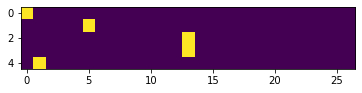

In [41]:
xenc = F.one_hot(xs, num_classes=27).float() # one_hot output is int64, we need to cast to float to use in nn
plt.imshow(xenc)

In [42]:
# Exponentiating logits, predicting log counts
logits = xenc @ W
counts = logits.exp()

# Probabilities for next character
probs = counts / counts.sum(1, keepdims=True) # softmax

In [40]:
probs.shape

torch.Size([5, 27])

In [43]:
nlls = torch.zeros(5)
for i in range(5):
    # i-th bigram:
    x = xs[i].item() # input char index
    y = ys[i].item() # label char index
    print('----------')
    print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
    print('input to the neural net:', x)
    print('output probabilities from the neural net:', probs[i])
    print('label (actual next character):', y)
    p = probs[i, y]
    print('probability assigned by the net to the correct character', p.item())
    logp = torch.log(p)
    print('log likelihood:', logp.item())
    nll = -logp
    print('negative log likelihood:', nll.item())
    nlls[i] = nll

print('============')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())


----------
bigram example 1: .e (indexes 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (actual next character): 5
probability assigned by the net to the correct character 0.01228625513613224
log likelihood: -4.399273872375488
negative log likelihood: 4.399273872375488
----------
bigram example 2: em (indexes 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
label (actual next character): 13
probability assigned by the net to the correct character 0.018050

### OPTIMIZATION

In [5]:
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples:', num)

# Initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator=g, requires_grad=True)


number of examples: 228146


In [ ]:
(W**2).mean()

In [8]:
# Gradient descent
for k in range(100):
    # Forward pass
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True) 
    loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean() # regularization is added
    print(loss.item())

    # Backward pass
    W.grad = None # Set gradients to 0
    loss.backward()

    # Update
    W.data += -50 * W.grad

3.7686190605163574
3.378786325454712
3.1610782146453857
3.027181386947632
2.9344804286956787
2.8672285079956055
2.81665301322937
2.777146100997925
2.745253801345825
2.7188305854797363
2.696505546569824
2.6773722171783447
2.6608059406280518
2.6463515758514404
2.6336653232574463
2.622471570968628
2.6125476360321045
2.6037065982818604
2.595794439315796
2.5886807441711426
2.5822560787200928
2.5764291286468506
2.5711233615875244
2.566272735595703
2.5618226528167725
2.5577261447906494
2.5539441108703613
2.550442695617676
2.547192335128784
2.5441696643829346
2.5413525104522705
2.538722038269043
2.536262035369873
2.5339581966400146
2.531797409057617
2.5297679901123047
2.527860164642334
2.526063919067383
2.5243709087371826
2.522773265838623
2.521263837814331
2.519836902618408
2.5184857845306396
2.5172054767608643
2.515990972518921
2.5148372650146484
2.5137407779693604
2.51269793510437
2.511704921722412
2.5107581615448
2.509855031967163
2.5089921951293945
2.5081686973571777
2.507380485534668
2.5

We roughly get the same loss with gradient based optimization compared to bigram counting

In [9]:
# Sampling from the model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix = 0 # start token
    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W
        counts = logits.exp()
        p = counts / counts.sum(1, keepdims=True)

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break;

    print(''.join(out))

mor.
axx.
minaymoryles.
kondmaisah.
anchthizarie.


Identical results :)